In [401]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import OrdinalEncoder

Data cleaning

In [402]:
df = pd.read_csv('chocolate.csv')

In [403]:
#len(df['specific_bean_origin_or_bar_name'].unique()) = 62
#len(df['specific_bean_origin_or_bar_name'].unique()) = 1398

In [404]:
#df['Unnamed: 0'] = 'index'
df = df.rename(columns={'Unnamed: 0': 'index'})


In [405]:
def standardization(df,features):
    
    df_scale = df.copy()
    feature_df = df_scale[features]
    scaled_features = StandardScaler().fit_transform(feature_df.values)
    df_scale[features] = scaled_features
    
    return df_scale

enc_features = ['beans','cocoa_butter', 'vanilla', 'lecithin', 'salt', 'sugar','sweetener_without_sugar']

#convert to binary
for var in enc_features:
    df[var] = [np.where("not" in x, 0, 1) for x in df[var]]

In [406]:
cleaned_df = df[['index','cocoa_percent', 'rating', 'beans', 'cocoa_butter', 'vanilla', 'lecithin', 'salt', 
                 'sugar','sweetener_without_sugar']]

#define feature columns
features = ['cocoa_percent', 'rating', 'beans', 'cocoa_butter', 'vanilla', 'lecithin', 'salt', 'sugar',
            'sweetener_without_sugar']

user_input = pd.DataFrame([['user_input','62.0','3.8','1','0','1','0','1','0','0']], columns=cleaned_df.columns)

#new_df = standardization(cleaned_df,features)

In [407]:
def cluster_predict(df,features,user_input,n_cluster):
    df = pd.concat([df,user_input])  # sorting by index 
    scale_df = standardization(df,features)
    model = KMeans(n_clusters=n_cluster, random_state=12).fit(scale_df[features])
    df['cluster_label'] = model.predict(df[features])
    return df

######call to make predictions
preds = cluster_predict(cleaned_df,features,user_input,8)

In [408]:
input_cluster = int(preds[preds['index']=='user_input']['cluster_label'])
input_cluster

5

In [409]:
top = 10
clusters = preds[preds['cluster_label']==input_cluster].reset_index(drop=True)
dist_matrix = pairwise_distances(clusters[features])
top_recs =  np.argsort(dist_matrix)[:, :(top+1)]
#clusters

In [410]:
ref_dicts = preds['index'].to_dict()
vectorization = np.vectorize(ref_dicts.get)(top_recs)
df_recs = pd.DataFrame(vectorization, columns=['index'] + [f'chocolate{i}' for i in range(1, 11)])
df_recs = df_recs[df_recs['index']=='user_input']

In [411]:
df_long = df_recs.melt(id_vars=['index'], var_name='rank', value_name='chocolate_bar')
df_long['rank'] = [int(x.replace('chocolate', '')) for x in df_long['rank']]
df_long

,index,rank,chocolate_bar
0,user_input,1,1
1,user_input,2,2164
2,user_input,3,438
3,user_input,4,1317
4,user_input,5,850
5,user_input,6,2
6,user_input,7,1421
7,user_input,8,908
8,user_input,9,278
9,user_input,10,550


In [412]:
df_long['chocolate_bar'] = [int(x) for x in df_long['chocolate_bar'] ]

In [413]:
#mapping chocolate bars by reference number 
df_final = pd.merge(df_long, df, left_on='chocolate_bar', right_on='index', how='inner')\
            .drop(['index_x','index_y'], axis=1)
df_final

,rank,chocolate_bar,ref,company,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,rating,...,cocoa_butter,vanilla,lecithin,salt,sugar,sweetener_without_sugar,first_taste,second_taste,third_taste,fourth_taste
0,1,1,2458,5150,U.S.A,2019,Dominican republic,"Zorzal, batch 1",76.0,3.50,...,1,0,0,0,1,0,cocoa,vegetal,savory,NaN
1,2,2164,1912,Wm,U.S.A,2016,Bolivia,"Wild Beniano, 2016, batch 128, Heirloom",76.0,3.50,...,1,0,0,0,1,0,nutty,fig,short length,NaN
2,3,438,1371,Castronovo,U.S.A,2014,Colombia,"Arauca, batch 280",76.0,3.50,...,1,0,0,0,1,0,caramel,sweet,delicate,NaN
3,4,1317,845,Marou,Vietnam,2012,Vietnam,Ba Ria,76.0,3.50,...,1,0,0,0,1,0,citrus,NaN,NaN,NaN
4,5,850,745,Fresco,U.S.A,2011,Venezuela,"Chuao, #218, MR, MC, batch 11-020",76.0,3.25,...,1,0,0,0,1,0,bready,nutty,earthy,intense
5,6,2,2454,5150,U.S.A,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,3.25,...,1,0,0,0,1,0,rich cocoa,fatty,bready,NaN
6,7,1421,2346,Millesime,Belgium,2019,Brazil,"Fazenda Leolinad, Bahia, 2017 H.",76.0,3.00,...,1,0,0,0,1,0,dry,sandy,dirt,empty
7,8,908,1359,Fruition,U.S.A,2014,Peru,Maranon,76.0,3.00,...,1,0,0,0,1,0,acidic,undefined,brownie,off
8,9,278,75,Bonnat,France,2006,Madagascar,Madagascar,75.0,3.75,...,1,0,0,0,1,0,mellow,tart,coffee,NaN
9,10,550,1984,Coppeneur,Germany,2017,Ghana,Ghana,75.0,3.75,...,1,0,0,0,1,0,oily,rich cocoa,nutty,NaN


Modeling

In [414]:
def model_lists(df, k_range=range(5,12), seed=12):
    dicts_model = {}
    for k in k_range:
        dicts_model[str(k)] = KMeans(n_clusters=k, random_state=seed).fit(df)
    models = list(dicts_model.values())
    return dicts_model,models

def cluster_visualization(df, model_list, k_range=range(5,12)):
    inertia_list = [m.inertia_ for m in model_list]
    si_list = [silhouette_score(df, i.labels_) for i in model_list]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    axs[0].plot(k_range, inertia_list, color='orange')
    axs[1].plot(k_range, si_list, color='blue')
    
    for i in range(2): 
        axs[i].set_xlabel('# clusters')
    for idx, name in zip([0,1,2], ['inertia', 'silhouette score']): 
        axs[idx].set_ylabel(name)
    
    plt.show()

In [424]:
model = KMeans(n_clusters=9, random_state=10).fit(df_scale[features])
silhouette_score(df_scale[features], model.labels_)

0.42677721806627067

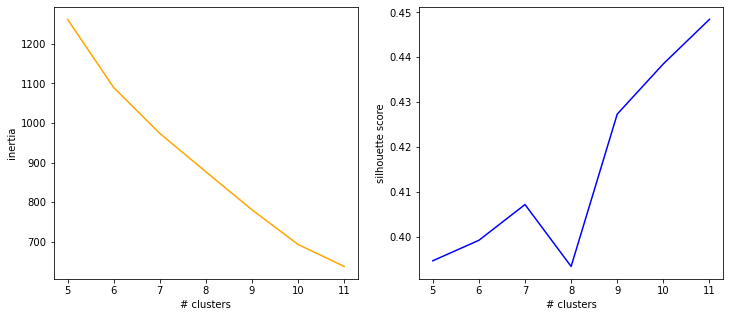

In [415]:
dicts_model, models = model_lists(df_scale)
cluster_visualization(df_scale, models)

In [149]:
opt_model = mod_dict[str(8)]
opt_cluster = 8

Recommendation

In [425]:
def get_top_recommendation(df,cluster_idx,features, top=10):
    
    return top_recs

def reformat_recommendation(df, recs, inputs):
    int2str = df_one_cluster[inputs].to_dict()
    map_cloest_info = np.vectorize(int2str.get)(closest_info)
    df_info = pd.DataFrame(map_cloest_info, columns=[inputs] + [f'rec{i}' for i in range(1, 11)])
    return df_info

In [428]:
df_result

,ref,rec1,rec2,rec3,rec4,rec5,rec6,rec7,rec8,rec9,rec10
0,1061,1173,206,15,688,241,654,2182,531,478,2242
1,1061,1173,206,15,688,241,654,2182,531,478,2242
2,2056,1772,308,688,15,1061,833,478,833,188,1173
3,311,797,316,552,206,363,387,439,24,316,552
4,288,1129,48,147,1061,576,2230,478,135,576,682
...,...,...,...,...,...,...,...,...,...,...,...
11,725,717,741,729,1057,1117,1359,1363,1215,1215,1359
12,729,725,717,741,1057,1117,1359,1363,1215,1359,1363
13,717,741,725,729,1117,1057,1359,1363,1215,1359,1363
14,741,717,725,729,1117,1057,1359,1363,1215,1359,1363


In [432]:
df_long = df_result.melt(id_vars=['ref'], var_name='the_rank', value_name='recommendation')
df_long['the_rank'] = df_long.the_rank.str.replace('rec', '').astype(int)
df_long = df_long.sort_values(['ref', 'the_rank'], ignore_index=True)

In [434]:

df_final = pd.merge(df_long, df, left_on='recommendation', right_on='ref', how='inner')\
             .drop('name', axis=1)\
             .sort_values(['input', 'the_rank'], ignore_index=True)
df_final['learn_more'] = df_final['recommendation'].apply(get_url)
df_final.abilities =  df_final.abilities.str.replace('[^a-zA-Z0-9, -]', '', regex=True)
df_final.input = df_final.input.str.lower()
df_final.type2 = df_final.type2.fillna('None')

KeyError: "['name'] not found in axis"